In [1]:
import pandas as pd
import pathlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report
from sklearn.preprocessing import normalize
from sklearn import svm
from collections import defaultdict
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
random.seed(42)
from numpy.random import seed
seed(42)

In [3]:
lfc_mb_filt=pd.read_csv('old_data/lfc_mb_filt.csv')
lfc_bin_mb_filt=pd.read_csv('old_data/lfc_bin_mb_filt.csv')

In [4]:
value_cols = [col for col in lfc_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']]
value_cols_lfc_bin = [col for col in lfc_bin_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']]

In [5]:
def rf_lr(mat, cols, C_lr):
    X=mat[cols].values
    y=mat['Functional_Category'].values
    n_classes=mat['Functional_Category'].nunique()
    preds_lr=np.zeros((len(y), n_classes))
    preds_rf=np.zeros((len(y), n_classes))
    #print(X,y)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, y_train=SMOTE().fit_resample(X_train, y_train)
        lr=LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C_lr, random_state=42)
        rf=RandomForestClassifier(n_estimators=100, random_state=42)
        lr.fit(X_train,y_train)
        rf.fit(X_train, y_train)
        preds_lr[test_index,:]=lr.predict_proba(X_test)
        preds_rf[test_index,:]=rf.predict_proba(X_test)
    preds_rf_lr=np.concatenate((preds_lr,preds_rf), axis=1)
    print (preds_rf_lr.shape)
    return preds_rf_lr, y

In [6]:
def ensemble_lr(X, y, C, name):
    n_classes=len(np.unique(y))
    confusion=np.zeros((n_classes, n_classes))
    skf=StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    train_index, test_index=list(skf.split(X,y))[0]
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train, y_train=SMOTE().fit_resample(X_train, y_train)
    lr=LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C, random_state=42)
    lr.fit(X_train,y_train)
    y_hat=lr.predict(X_test)
    confusion+=confusion_matrix(y_test, y_hat)
    print (classification_report(y_test, y_hat))
    confusion=normalize(confusion, axis=1, norm='l1')
    accuracy=accuracy_score(y_test, y_hat)
    print (accuracy)
    col_names=['PE/PPE', 'cell wall and\ncell processes', 'information pathways', 'insertion seqs\nand phages', 'intermediary metabolism\nand respiration', 'lipid metabolism', 'regulatory proteins', 'virulence, detoxification,\nadaptation']
    confusion=confusion=pd.DataFrame(confusion, columns=col_names, index=col_names)
    #confusion=pd.DataFrame(confusion, columns=clf.classes_, index=clf.classes_)
    plt.figure(figsize=(7,7))
    rc={'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 14}
    sns.set(rc=rc)
    heat=sns.heatmap(confusion, annot=True, linewidths=.1, fmt='1.2f', square=True, cbar=False)
    heat.set(xlabel='PREDICTED CLASS', ylabel='TRUE CLASS', title=name)
#     fig = heat.get_figure()
#     fig.savefig('ensemble_old_data_with_imputed_preds.png', dpi=500, bbox_inches = "tight")
    return None
    
    
    

In [7]:
X_ensemble,y_ensemble=rf_lr(lfc_bin_mb_filt, value_cols_lfc_bin, C_lr=10)

(2948, 16)


                                         precision    recall  f1-score   support

                                 PE/PPE       0.52      0.71      0.60        83
           cell wall and cell processes       0.42      0.15      0.22       386
                   information pathways       0.20      0.40      0.26       121
              insertion seqs and phages       0.50      0.74      0.60        73
intermediary metabolism and respiration       0.51      0.12      0.19       467
                       lipid metabolism       0.17      0.49      0.25       136
                    regulatory proteins       0.11      0.19      0.14        99
  virulence, detoxification, adaptation       0.19      0.34      0.24       110

                              micro avg       0.27      0.27      0.27      1475
                              macro avg       0.33      0.39      0.31      1475
                           weighted avg       0.38      0.27      0.25      1475

0.2677966101694915


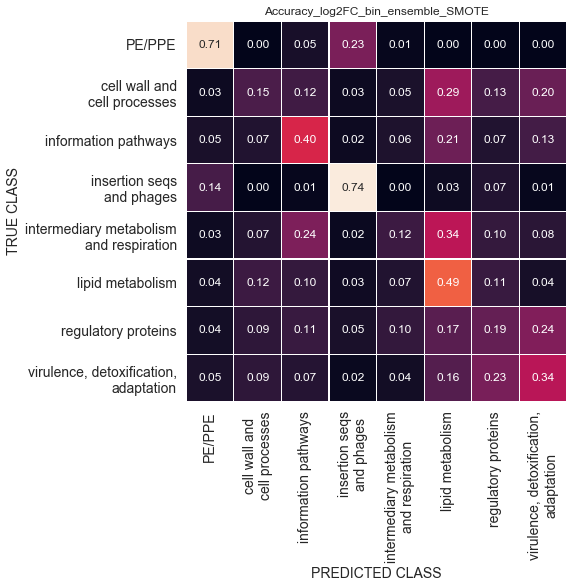

In [8]:
ensemble_lr(X_ensemble, y_ensemble, C=10, name='Accuracy_log2FC_bin_ensemble_SMOTE')

In [9]:
## with std data
lfc_mb_filt=pd.read_csv('../data/standardized_data/cleaned_ML/lfc_mb_filt.csv')
lfc_bin_mb_filt=pd.read_csv('../data/standardized_data/cleaned_ML/lfc_bin_mb_filt.csv')

value_cols = [col for col in lfc_mb_filt.columns if col not in ['ORF', 'Functional_Category']]
value_cols_lfc_bin = [col for col in lfc_bin_mb_filt.columns if col not in ['ORF', 'Functional_Category']]

In [10]:
X_ensemble,y_ensemble=rf_lr(lfc_bin_mb_filt, value_cols_lfc_bin, C_lr=10)

(2937, 16)


                                         precision    recall  f1-score   support

                                 PE/PPE       0.22      0.62      0.33        81
           cell wall and cell processes       0.36      0.10      0.16       386
                   information pathways       0.20      0.42      0.27       121
              insertion seqs and phages       0.29      0.54      0.38        71
intermediary metabolism and respiration       0.57      0.11      0.18       467
                       lipid metabolism       0.20      0.27      0.23       135
                    regulatory proteins       0.10      0.22      0.13        99
  virulence, detoxification, adaptation       0.13      0.29      0.18       110

                              micro avg       0.22      0.22      0.22      1470
                              macro avg       0.26      0.32      0.23      1470
                           weighted avg       0.35      0.22      0.20      1470

0.21768707482993196


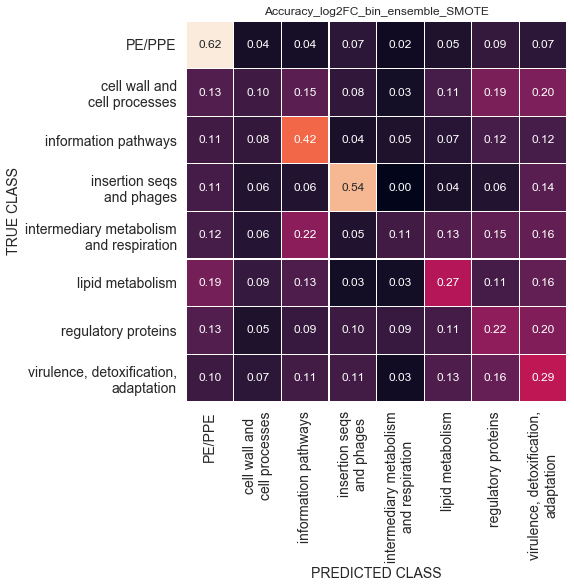

In [11]:
ensemble_lr(X_ensemble, y_ensemble, C=10, name='Accuracy_log2FC_bin_ensemble_SMOTE')

In [18]:
#with non-std data minus imputed

In [19]:
lfc_mb_filt=pd.read_csv('old_data/lfc_mb_filt.csv')
lfc_bin_mb_filt=pd.read_csv('old_data/lfc_bin_mb_filt.csv')

In [20]:
list(lfc_bin_mb_filt.columns)

['Rv_ID',
 '2003A_Sassetti_log2FC',
 '2003B_Sassetti_log2FC',
 '2005_Rengarajan_log2FC',
 '2006_Joshi_GI_1_log2FC',
 '2006_Joshi_GI_2_log2FC',
 '2011_Griffin_2_log2FC',
 '2013_Zhang_1_log2FC',
 '2013_Zhang_2_log2FC',
 '2013_Zhang_3A_log2FC',
 '2013_Zhang_3B_log2FC',
 '2013_Zhang_3C_log2FC',
 '2013_Zhang_3D_log2FC',
 '2016_Korte_log2FC',
 '2017_Mishra_1A_log2FC',
 '2017_Mishra_1B_log2FC',
 '2017_Mishra_1C_log2FC',
 '2017_Mishra_1D_log2FC',
 '2018_Rittershaus_1A_log2FC',
 '2018_Rittershaus_1B_log2FC',
 '2012_Zhang_log2FC',
 '2015_Kieser_GI_1_log2FC',
 '2015_Kieser_GI_2_log2FC',
 '2015_Kieser_GI_3_log2FC',
 '2015_Mendum_log2FC',
 '2016_Nambi_log2FC',
 '2017_Xu_1A_log2FC',
 '2017_Xu_1B_log2FC',
 '2017_Xu_1C_log2FC',
 '2017_Xu_1D_log2FC',
 '2017_Xu_1E_log2FC',
 '2018_Carey_1A_log2FC',
 '2018_Carey_1B_log2FC',
 '2018_Carey_1C_log2FC',
 '2018_Carey_1D_log2FC',
 '2018_Carey_1E_log2FC',
 '2018_Carey_1F_log2FC',
 '2018_Carey_1G_log2FC',
 '2018_Carey_1H_log2FC',
 '2017B_DeJesus_1A_log2FC',
 '2017

In [21]:
cols_to_remove=['2003A_Sassetti', '2003B_Sassetti', '2011_Griffin_2', '2013_Zhang_2', '2013_Zhang_1', '2013_Zhang_3A', '2013_Zhang_3B', '2013_Zhang_3C', '2013_Zhang_3D', '2018_Rittershaus_1A', '2018_Rittershaus_1B', '2016_Korte', '2012_Zhang', '2015_Mendum', '2017_Mishra_1A', '2017_Mishra_1B', '2017_Mishra_1C', '2017_Mishra_1D', '2005_Rengarajan', '2006_Joshi_GI_1', '2006_Joshi_GI_2']
cols_to_remove_all=[col+'_log2FC' for col in cols_to_remove]+cols_to_remove

In [22]:
cols_to_remove_all

['2003A_Sassetti_log2FC',
 '2003B_Sassetti_log2FC',
 '2011_Griffin_2_log2FC',
 '2013_Zhang_2_log2FC',
 '2013_Zhang_1_log2FC',
 '2013_Zhang_3A_log2FC',
 '2013_Zhang_3B_log2FC',
 '2013_Zhang_3C_log2FC',
 '2013_Zhang_3D_log2FC',
 '2018_Rittershaus_1A_log2FC',
 '2018_Rittershaus_1B_log2FC',
 '2016_Korte_log2FC',
 '2012_Zhang_log2FC',
 '2015_Mendum_log2FC',
 '2017_Mishra_1A_log2FC',
 '2017_Mishra_1B_log2FC',
 '2017_Mishra_1C_log2FC',
 '2017_Mishra_1D_log2FC',
 '2005_Rengarajan_log2FC',
 '2006_Joshi_GI_1_log2FC',
 '2006_Joshi_GI_2_log2FC',
 '2003A_Sassetti',
 '2003B_Sassetti',
 '2011_Griffin_2',
 '2013_Zhang_2',
 '2013_Zhang_1',
 '2013_Zhang_3A',
 '2013_Zhang_3B',
 '2013_Zhang_3C',
 '2013_Zhang_3D',
 '2018_Rittershaus_1A',
 '2018_Rittershaus_1B',
 '2016_Korte',
 '2012_Zhang',
 '2015_Mendum',
 '2017_Mishra_1A',
 '2017_Mishra_1B',
 '2017_Mishra_1C',
 '2017_Mishra_1D',
 '2005_Rengarajan',
 '2006_Joshi_GI_1',
 '2006_Joshi_GI_2']

In [28]:
len(cols_to_remove_all)

42

In [23]:
print(lfc_bin_mb_filt.shape)
lfc_bin_mb_filt=lfc_bin_mb_filt.drop(columns=cols_to_remove_all)
print(lfc_bin_mb_filt.shape)

(2948, 116)
(2948, 74)


In [24]:
value_cols_lfc_bin = [col for col in lfc_bin_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']]

In [25]:
X_ensemble,y_ensemble=rf_lr(lfc_bin_mb_filt, value_cols_lfc_bin, C_lr=10)

(2948, 16)


                                         precision    recall  f1-score   support

                                 PE/PPE       0.52      0.70      0.59        83
           cell wall and cell processes       0.35      0.15      0.21       386
                   information pathways       0.19      0.41      0.26       121
              insertion seqs and phages       0.47      0.73      0.57        73
intermediary metabolism and respiration       0.35      0.05      0.09       467
                       lipid metabolism       0.16      0.27      0.20       136
                    regulatory proteins       0.08      0.20      0.12        99
  virulence, detoxification, adaptation       0.11      0.29      0.16       110

                              micro avg       0.23      0.23      0.23      1475
                              macro avg       0.28      0.35      0.28      1475
                           weighted avg       0.30      0.23      0.20      1475

0.22508474576271187


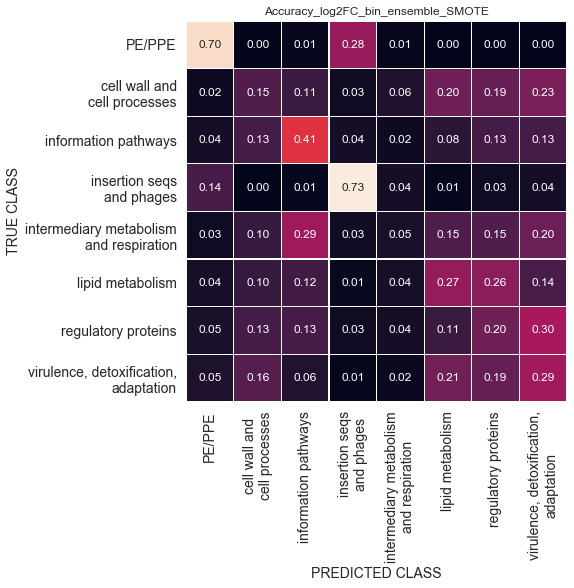

In [26]:
ensemble_lr(X_ensemble, y_ensemble, C=10, name='Accuracy_log2FC_bin_ensemble_SMOTE')